In [1]:
!which python; python -V;

# This makes the diagrams to more reliably appear in Jupyter environment
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# This will cause the ephemerides to be imported from JPL horizons system
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

/home/thomson/devel/perylune/venv/bin/python
Python 3.8.5


<ScienceState solar_system_ephemeris: 'jpl'>

In [3]:
from poliastro.bodies import Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune, Sun, Pluto
from poliastro.twobody import Orbit
from poliastro.constants import GM_earth

from perylune.orbit_tools import *
from perylune.interplanetary import *
from perylune.constants import *

from astropy import units as u
from astropy import time
import numpy as np

In [4]:
from poliastro.ephem import Ephem
from poliastro.util import time_range
import plotly.graph_objs as go

date_launch = time.Time("2020-01-01 00:00", scale="utc").tdb
date_arrival = time.Time("2020-12-31 23:59", scale="utc").tdb

earth = Ephem.from_body(Earth, time_range(date_launch, end=date_arrival))
mars = Ephem.from_body(Mars, time_range(date_launch, end=date_arrival))

# Solve for departure and target orbits
ss_earth = Orbit.from_ephem(Sun, earth, date_launch)

1 x 1 AU x 23.4 deg (HCRS) orbit around Sun (☉) at epoch 2020-01-01 00:01:09.184 (TDB)
a(𝑎)=152302945.05km, b=152250012.48km, e=0.03, i=23.44deg raan(Ω)=0.00deg argp(𝜔)=97.18deg nu(𝜈)=2.70deg
period=32418021.04s perapis=148287877km(147592177.05km) apoapsis=156318013km(155622313.06km)


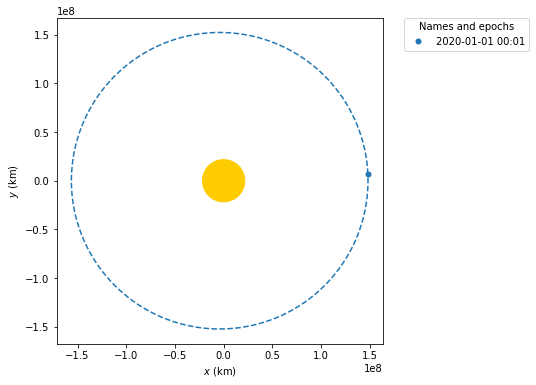

In [6]:
ss_earth.plot()
print_orb(ss_earth)

In [5]:
# Calculate delta-v necessary to reach escape velocity for circular orbit. The values returned are current position, periapsis, apoapis.
# No surprises here - it's perfectly circular, so it's always the same.
escape_delta_v(orb1, False)

(<Quantity 3212.16227604 m / s>,
 <Quantity 3212.16227604 m / s>,
 <Quantity 3212.16227604 m / s>)

In [6]:
# The situation for eliptical orbit is more interesting. The delta-v for periapsis burn is 2869 m/s, which is the smallest value
# for this orbit and up to 3516 for apoapsis (when the velocity is smallest, so extra delta-v is needed to escape)
escape_delta_v(orb2, False)

(<Quantity 2869.63167184 m / s>,
 <Quantity 2869.63167184 m / s>,
 <Quantity 3516.37639716 m / s>)

In [7]:
# Here's an utility function that returns a (semi-major axis) and e (eccentricity) for min and max altitude orbits
apses_to_ae(400, 300)
apses_to_ae(300*u.km , 400*u.km, Earth.R)

(<Quantity 6728.1366 km>, <Quantity 0.00743148>)

In [8]:
# To obtain data, head to Horizons (https://ssd.jpl.nasa.gov) and use the following parameters:
# Ephemepris type: ELEMENTS
# Target body: <whatever planet needed, e.g. Mars>
# Center: Sun
# Time span: pick any date
# Table settings: output inits=KM-S
# Display/Output: plain text

# For example, Earth returns the following data for 2020-Nov-03
#2459156.500000000 = A.D. 2020-Nov-03 00:00:00.0000 TDB 
# EC= 1.623243125148644E-02 QR= 1.470544578776156E+08 IN= 4.337517056126222E-03
# OM= 1.956969904857147E+02 W = 2.693660952667993E+02 Tp=  2459219.993764857296
# N = 1.142090613016157E-05 MA= 2.973464932363198E+02 TA= 2.956789660740816E+02
# A = 1.494808962493945E+08 AD= 1.519073346211734E+08 PR= 3.152114165874045E+07

a = 1.494808962493945E+08 * u.km
e = 1.623243125148644E-02 * u.one
inc = 4.337517056126222E-03 * u.deg
raan = 1.956969904857147E+02 * u.deg
argp = 2.693660952667993E+02 * u.deg
nu = 2.956789660740816E+02 * u.deg

# Orbital data from Horizons
orbit_earth = Orbit.from_classical(Sun, a, e, inc, raan, argp, nu)

# MARS
# EC= 9.333873836923647E-02 QR= 2.066557040253017E+08 IN= 1.847950769090515E+00
# OM= 4.949400395133841E+01 W = 2.866239949629700E+02 Tp=  2459064.901374706533
# N = 6.065617422097314E-06 MA= 4.800403158507560E+01 TA= 5.659109019293314E+01
# A = 2.279304441149290E+08 AD= 2.492051842045562E+08 PR= 5.935092422553787E+07
a = 2.279304441149290E+08 * u.km
e = 1.623243125148644E-02 * u.one
inc = 1.847950769090515E+00 * u.deg
raan = 4.949400395133841E+01 * u.deg
argp = 2.866239949629700E+02  * u.deg
nu = 5.659109019293314E+01 * u.deg

# TODO: insert actual date
orbit_mars = Orbit.from_classical(Sun, a, e, inc, raan, argp, nu)

hoh = Maneuver.hohmann(orbit_earth, orbit_mars.a)
orb3,orb4 = orbit_earth.apply_maneuver(hoh, intermediate=True)

In [9]:
from poliastro.plotting import OrbitPlotter3D

op = OrbitPlotter3D()
op.plot(orbit_earth, label="Earth")
op.plot(orbit_mars, label="Mars")
op.plot(orb3, label="transfer")
#op.plot(orb4, label="arrival")
#op.plot(orb3, label="Transfer orbit - Hohmann transfer")
#op.plot(orb4, label="Final orbit - GEO")

Number of impulses: 2, Total cost: 5.598702 km / s

In [10]:
get_cost(hoh, 0)

<Quantity 2838.71961742 m / s>

In [11]:
get_cost(hoh,1)

<Quantity 2759.98284821 m / s>

In [12]:
hoh

Number of impulses: 2, Total cost: 5.598702 km / s

In [13]:
from astropy import time
from poliastro.ephem import Ephem
from poliastro.util import time_range

# Mars 2020
date_launch = time.Time("2020-07-20 11:50", scale="utc").tdb
date_arrival = time.Time("2021-02-18 12:00", scale="utc").tdb

# Ideal, read from the porkchop
date_launch = time.Time("2020-07-15 11:50", scale="utc").tdb
date_arrival = time.Time("2021-01-20 12:00", scale="utc").tdb

earth = Ephem.from_body(Earth, time_range(date_launch, end=date_arrival))
mars = Ephem.from_body(Mars, time_range(date_launch, end=date_arrival))

# Solve for departure and target orbits
ss_earth = Orbit.from_ephem(Sun, earth, date_launch)
ss_mars = Orbit.from_ephem(Sun, mars, date_arrival)

# Solve for the transfer maneuver
man_lambert = Maneuver.lambert(ss_earth, ss_mars)

print(man_lambert)

# Get the transfer and final orbits
ss_trans, ss_target = ss_earth.apply_maneuver(man_lambert, intermediate=True)

from poliastro.plotting import OrbitPlotter3D
plotter = OrbitPlotter3D()
plotter.set_attractor(Sun)

plotter.plot_ephem(earth, date_launch, label="Earth at launch position")
plotter.plot_ephem(mars, date_arrival, label="Mars at arrival position")
plotter.plot_trajectory(ss_trans.sample(max_anomaly=180 * u.deg), color="black", label="Transfer orbit")
plotter.set_view(30 * u.deg, 260 * u.deg, distance=3 * u.km)



Number of impulses: 2, Total cost: 6.884949 km / s
